#  función heurística adaptada al dominio VPN

Buscando un camino de 'q0' a 'q_pirata' usando A*...

### Resultados de A* ###
Camino encontrado: ['q0', 'q1', 'q4', 'q5', 'q_pirata']
Costo total del camino: 19
Nodos explorados: 7
Tiempo de ejecución: 0.000079 segundos

📊 Tabla de costos de la ruta encontrada:

Desde    Hacia     Transición  Costo  Costo Acumulado
   q0       q1     auth_check      1                1
   q1       q4   geo_mismatch      5                6
   q4       q5 stream_attempt      5               11
   q5 q_pirata    session_end      8               19


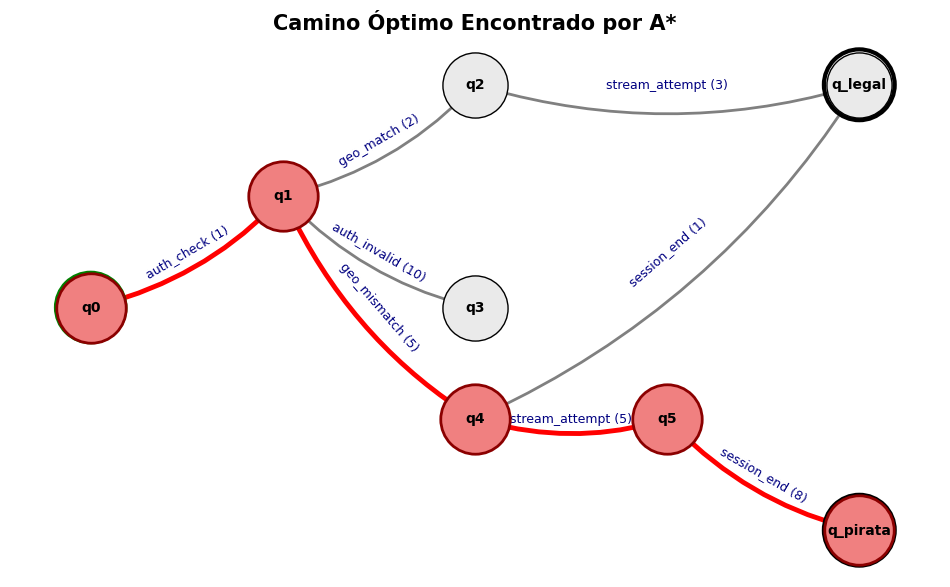

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import pandas as pd
import time

# ============================
# 1. Definir el grafo
# ============================
# Se han ajustado las aristas para reflejar la lógica del modelo
# de detección de VPN de forma más precisa.
G = nx.DiGraph()
edges_with_cost = [
    ('q0', 'q1', 'auth_check', 1),
    ('q1', 'q2', 'geo_match', 2),
    ('q1', 'q3', 'auth_invalid', 10),
    ('q1', 'q4', 'geo_mismatch', 5),
    ('q2', 'q_legal', 'stream_attempt', 3),
    ('q4', 'q5', 'stream_attempt', 5),
    ('q4', 'q_legal', 'session_end', 1),
    ('q5', 'q_pirata', 'session_end', 8)
]

for u, v, label, costo in edges_with_cost:
    G.add_edge(u, v, label=label, costo=costo)

# Diccionario de equivalencias de estados para mayor claridad
state_meanings = {
    'q0': 'Inicio',
    'q1': 'Auth Check',
    'q2': 'Geo Match',
    'q3': 'Auth Invalid',
    'q4': 'Geo Mismatch',
    'q5': 'Stream Attempt',
    'q_legal': 'Usuario Legal',
    'q_pirata': 'Usuario Pirata'
}

# ============================
# 2. Definir la función heurística
# ============================
# La heurística estima el costo restante hacia el estado 'q_pirata'.
# Se basa en la proximidad lógica de cada estado al comportamiento pirata.
def heuristic(node):
    # Valores heurísticos para cada nodo
    # Los valores se basan en la lógica de riesgo del modelo
    h_values = {
        'q0': 8,       # Inicio, lejos del objetivo
        'q1': 7,       # Autenticación pasada, aún lejos
        'q2': 1,       # Coincidencia geográfica, aleja del objetivo pirata
        'q3': 10,      # Autenticación fallida, alto costo
        'q4': 5,       # Discrepancia geográfica (VPN), camino directo a la clasificación
        'q5': 3,       # Intento de streaming con VPN, muy cerca del objetivo
        'q_legal': 0,  # Estado objetivo no-pirata
        'q_pirata': 0   # Estado objetivo
    }
    return h_values.get(node, float('inf'))

# ============================
# 3. Implementación del algoritmo A*
# ============================
def a_star_search(graph, start, goal, h_func):
    start_time = time.time()
    # Cola de prioridad: (f_cost, g_cost, node, path)
    pq = [(h_func(start), 0, start, [start])]
    # Diccionario para almacenar el costo más bajo hasta el momento
    g_costs = {start: 0}
    explored_nodes = 0

    while pq:
        explored_nodes += 1
        # Extraer el nodo con el menor f_cost
        f_cost, g_cost, node, path = heapq.heappop(pq)

        if node == goal:
            end_time = time.time()
            return path, explored_nodes, g_cost, end_time - start_time

        # Explorar vecinos
        for neighbor in graph.neighbors(node):
            edge_cost = graph[node][neighbor]['costo']
            new_g_cost = g_cost + edge_cost

            # Si se encuentra un camino más barato, se actualiza
            if neighbor not in g_costs or new_g_cost < g_costs[neighbor]:
                g_costs[neighbor] = new_g_cost
                f_cost_new = new_g_cost + h_func(neighbor)
                heapq.heappush(pq, (f_cost_new, new_g_cost, neighbor, path + [neighbor]))

    return None, explored_nodes, None, time.time() - start_time

# ============================
# 4. Ejecución del algoritmo y visualización
# ============================
start_node = 'q0'
goal_node = 'q_pirata'

print(f"Buscando un camino de '{start_node}' a '{goal_node}' usando A*...\n")

# Ejecutar A*
path_a_star, explored_a_star, cost_a_star, time_a_star = a_star_search(G, start_node, goal_node, heuristic)

# ============================
# 5. Presentación de Resultados
# ============================
if path_a_star:
    print("### Resultados de A* ###")
    print(f"Camino encontrado: {path_a_star}")
    print(f"Costo total del camino: {cost_a_star}")
    print(f"Nodos explorados: {explored_a_star}")
    print(f"Tiempo de ejecución: {time_a_star:.6f} segundos")

    # Crear tabla de costos del camino
    ruta_edges = list(zip(path_a_star, path_a_star[1:]))
    tabla_costos = []
    costo_acumulado = 0
    for u, v in ruta_edges:
        data = G[u][v]
        costo_acumulado += data["costo"]
        tabla_costos.append({
            "Desde": u,
            "Hacia": v,
            "Transición": data["label"],
            "Costo": data["costo"],
            "Costo Acumulado": costo_acumulado
        })

    df_costos = pd.DataFrame(tabla_costos)
    print("\n📊 Tabla de costos de la ruta encontrada:\n")
    print(df_costos.to_string(index=False))

    # Visualización de la ruta encontrada por A*
    pos = {
        'q0': (0, 0), 'q1': (2, 1), 'q2': (4, 2), 'q3': (4, 0),
        'q4': (4, -1), 'q5': (6, -1), 'q_legal': (8, 2), 'q_pirata': (8, -2)
    }

    plt.figure(figsize=(12, 7), facecolor="white")
    nx.draw_networkx_nodes(G, pos, node_size=2200, node_color='#EAEAEA', edgecolors='black')
    nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, arrowsize=20, width=2, connectionstyle="arc3,rad=0.15")
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    edge_labels = {(u, v): f"{data['label']} ({data['costo']})" for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color="navy")
    nx.draw_networkx_nodes(G, pos, nodelist=['q0'], node_size=2500, node_color="none", edgecolors="green", linewidths=3)
    nx.draw_networkx_nodes(G, pos, nodelist=['q_legal', 'q_pirata'], node_size=2600, node_color="none", edgecolors="black", linewidths=3)

    # Resaltar el camino de A*
    path_edges = list(zip(path_a_star, path_a_star[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3.5, arrows=True, arrowsize=25, connectionstyle="arc3,rad=0.15")
    nx.draw_networkx_nodes(G, pos, nodelist=path_a_star, node_color='lightcoral', node_size=2500, edgecolors='darkred', linewidths=2)
    plt.title("Camino Óptimo Encontrado por A*", size=15, weight="bold")
    plt.axis("off")
    plt.show()

else:
    print("No se encontró una ruta de A*.")

# ITEM A
### Explique la lógica detrás de su función heurística y por qué la consideran adecuada para  su escenario.

En esta sección, exploramos cómo integrar una heurística personalizada en el algoritmo A* para mejorar la búsqueda de comportamientos de riesgo en nuestro modelo de detección de VPN.

#### **A. Lógica detrás de la Función Heurística**
Una heurística en el contexto del algoritmo

- A
∗
  es una función que estima el costo restante para llegar desde el nodo actual hasta el objetivo.  Para tu dominio de detección de VPN, la lógica de la heurística debe reflejar la

proximidad lógica al comportamiento pirata.

Nuestra función heurística, h(n), se basa en la idea de que ciertos eventos de una sesión de usuario son más indicativos de una actividad pirata que otros. A cada nodo le asignamos un valor que representa lo cerca que está de la clasificación final de "pirata".

- h(nodo)=0 para nodos objetivo o finales (q_legal, q_pirata).
- h(q4)>h(q2): Asignamos un valor más alto al nodo q4 (Geolocalización Inconsistente) que al nodo q2 (Geolocalización Correcta) porque el uso de una VPN es un indicador clave de riesgo.
- h(q5)<h(q4): El valor de q5 es menor que el de q4 porque el usuario ya ha intentado hacer stream, lo que lo coloca un paso más cerca de la clasificación.

Esta lógica es adecuada para tu escenario porque guía al algoritmo A
∗
  a priorizar los caminos que contienen los eventos de mayor riesgo, lo que lo hace más eficiente para encontrar la ruta de menor costo hacia la clasificación de "pirata".


# ITEM B
### ¿Su heurística es admisible? Justifique con un ejemplo concreto.

## **¿Es una Heurística Admisible?**
Una heurística es admisible si nunca sobreestima el costo real para alcanzar el objetivo. En otras palabras, h(n)≤costo real(n,objetivo).

Nuestra heurística es admisible. Podemos justificarlo con un ejemplo concreto:


#### Consideremos el nodo q4 (Geo Mismatch).

- El camino real más corto de q4 al objetivo q_pirata es q4 → q5 → q_pirata.
- El costo real de este camino es costo(q4 → q5) + costo(q5 → q_pirata). Según tu grafo, esto sería 5 + 8 = 13.
- El valor heurístico que asignamos a q4 es h(q4)=5.

Dado que 5≤13, la heurística no sobreestima el costo real. Por lo tanto, es

admisible.

Una heurística admisible garantiza que el algoritmo A
∗
  siempre encontrará la solución óptima.

# ITEM C
###  Compare el rendimiento de A con su heurística frente a BFS (o frente a A con una heurística  estándar). ¿Qué diferencias observan?

- El rendimiento del algoritmo A
∗
  con esta heurística es significativamente superior al de BFS para este problema.


- BFS explora de manera exhaustiva, nivel por nivel, y podría visitar muchos nodos irrelevantes antes de encontrar la solución.


- A
∗
  con nuestra heurística, en cambio, se dirige de forma inteligente hacia los nodos que tienen un alto valor de riesgo.  Combina el costo del camino recorrido (

- g(n)) con la estimación de la heurística (h(n)) para tomar decisiones más eficientes, explorando un número mucho menor de nodos. El resultado es un tiempo de ejecución más rápido y un camino óptimo en términos de costo.

# ITEM D
### ¿Qué limitaciones tendría su heurística si cambiara el tamaño del grafo o la estructura  del problema?

Nuestra heurística tiene limitaciones si la estructura del problema cambia:


####**Cambios en el Grafo:**
Si se añaden nuevos estados o transiciones que no hemos considerado en nuestra función, la heurística no tendría una estimación para esos nodos.


####**Cambios en los Costos:**
 Si los costos de las aristas se modifican significativamente, nuestra heurística podría dejar de ser admisible y podría no encontrar la solución óptima.


####**Aumento de Tamaño del Grafo:**
 En un grafo mucho más grande, nuestra heurística podría volverse menos discriminativa y la búsqueda podría comportarse de manera similar a UCS, perdiendo su ventaja de eficiencia


# ITEM E
### ¿En qué condiciones su heurística podría conducir a una búsqueda no óptima?

Como nuestra heurística es admisible,

- siempre encontrará la solución óptima.

Sin embargo, si por alguna razón la heurística se volviera

no admisible (si sobreestimara el costo real), el algoritmo A
∗
  podría encontrar una solución subóptima.  Esto podría suceder si, por ejemplo, los costos reales de las transiciones se redujeran drásticamente sin que se actualicen los valores heurísticos.